In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

c:\Users\visionary\AppData\Local\miniconda3\envs\py310_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:

import pandas as pd
# Specify the path to your CSV file
csv_path = "data/fashion.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Now df contains all the data from fashion.csv
print(df.tail())  # Quick peek at the first few rows

      ProductId Gender  Category SubCategory   ProductType Colour   Usage  \
2901      51755  Women  Footwear       Shoes  Casual Shoes  Black  Casual   
2902      47630  Women  Footwear       Shoes         Flats   Blue  Casual   
2903      32836  Women  Footwear       Shoes         Flats   Pink  Casual   
2904      35821  Women  Footwear       Shoes         Heels  Black  Casual   
2905      18553  Women  Footwear       Shoes         Heels   Blue  Casual   

                             ProductTitle      Image  \
2901            Catwalk Women Black Shoes  51755.jpg   
2902      Carlton London Women Blue Shoes  47630.jpg   
2903     Grendha Women Flori Pink Sandals  32836.jpg   
2904            Enroute Women Black Heels  35821.jpg   
2905  Catwalk Women Mary Janes Blue Flats  18553.jpg   

                                               ImageURL  
2901  http://assets.myntassets.com/v1/images/style/p...  
2902  http://assets.myntassets.com/v1/images/style/p...  
2903  http://assets.myntas

In [21]:
image_dirs = [
    r"D:\Anand\Jsearch_ai\image search\data\Apparel\Boys\Images\images_with_product_ids",
    r"D:\Anand\Jsearch_ai\image search\data\Apparel\Girls\Images\images_with_product_ids",
    r"D:\Anand\Jsearch_ai\image search\data\Footwear\Men\Images\images_with_product_ids",
    r"D:\Anand\Jsearch_ai\image search\data\Footwear\Women\Images\images_with_product_ids"
]

all_image_paths = []
for directory in image_dirs:
    paths = glob.glob(os.path.join(directory, "*.jpg"))
    all_image_paths.extend(paths)

print(f"Found {len(all_image_paths)} images.")


Found 2906 images.


In [24]:
import os
import faiss
import torch
import numpy as np
from PIL import Image
from sentence_transformers import SentenceTransformer

def parse_product_id_from_path(path):
    """
    Extract a product ID by removing the extension from the filename.
    e.g., '42419.jpg' -> 42419
    """
    filename = os.path.basename(path)
    product_id_str = os.path.splitext(filename)[0]
    return int(product_id_str)  # or return the string if you prefer

def build_faiss_index(image_paths, model_name='clip-ViT-B-32'):
    # 1) Check if CUDA is available; if so, use GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 2) Load CLIP model from SentenceTransformers, forcing it to use the chosen device
    model = SentenceTransformer(model_name, device=device)
    
    embeddings = []
    product_ids = []
    
    # 3) Encode each image (on GPU if available)
    for path in image_paths:
        pil_image = Image.open(path).convert("RGB")
        
        # Encode using CLIP on the selected device
        embedding = model.encode(pil_image)
        
        embeddings.append(embedding)
        
        # Parse the product ID from the filename
        pid = parse_product_id_from_path(path)
        product_ids.append(pid)
    
    # 4) Prepare data for FAISS
    embeddings = np.array(embeddings, dtype=np.float32)
    product_ids = np.array(product_ids, dtype=np.int64)  # FAISS requires int64 IDs
    
    dimension = embeddings.shape[1]
    index_flat = faiss.IndexFlatIP(dimension)  # Inner-product index
    
    # Wrap index in an ID map so we can store product IDs
    index = faiss.IndexIDMap(index_flat)
    
    # 5) Add our vectors
    index.add_with_ids(embeddings, product_ids)
    print("FAISS index built. Total items:", index.ntotal)
    
    return index


In [25]:
index = build_faiss_index(all_image_paths)


Using device: cuda
FAISS index built. Total items: 2906


In [26]:
# Save index
faiss.write_index(index, "fashion.index")
print("Index saved to fashion.index")

# Load index
loaded_index = faiss.read_index("fashion.index")
print("Index loaded from disk. Total items:", loaded_index.ntotal)


Index saved to fashion.index
Index loaded from disk. Total items: 2906


In [27]:
# Save the image paths to a text file
with open("fashion.paths", "w") as f:
    for path in all_image_paths:
        f.write(path + "\n")

# Reload them later
with open("fashion.paths", "r") as f:
    all_image_paths = [line.strip() for line in f.readlines()]


In [36]:
def search_index(query, index, model, top_k=5):
    # If 'query' is a path to an image, load & encode that image
    if os.path.isfile(query) and query.lower().endswith(('.png', '.jpg', '.jpeg')):
        pil_image = Image.open(query).convert("RGB")
        query_embedding = model.encode(pil_image)
    else:
        # Otherwise treat the query as text
        query_embedding = model.encode(query)
    
    query_embedding = query_embedding.astype(np.float32).reshape(1, -1)
    distances, ids = index.search(query_embedding, top_k)
    
    return ids[0], distances[0]

# Example usage:
model = SentenceTransformer('clip-ViT-B-32')
product_ids, sim_scores = search_index("A pair of pink sneakers", index, model)
print("Top matching product IDs:", product_ids)
print("Similarity scores:", sim_scores)


Top matching product IDs: [34518 36418 15261 24455  5927]
Similarity scores: [26.833954 26.147465 26.008865 25.87852  25.809116]


In [31]:
# Provide a path to an image on your machine
test_image_path = r"D:\Anand\Jsearch_ai\image search\data\Apparel\Girls\Images\images_with_product_ids\2700.jpg"
    
    # Query the index with that image
product_ids, sim_scores = search_index(test_image_path, index, model, top_k=20)
    
print("Top matching product IDs:", product_ids)
print("Similarity scores:", sim_scores)

Top matching product IDs: [ 2700  2701  2732  2730  4719  4215  2708 43585 43584  5215  3897  3855
  2702 41299  2716  2707  2704  5417  2728  3903]
Similarity scores: [112.047165 105.49396  103.03407  102.88617  102.674484 102.27339
 101.095505 100.814644 100.75023  100.60527  100.16279  100.14245
 100.01488   99.78554   99.5622    99.16908   99.01839   99.013245
  98.47926   98.390625]


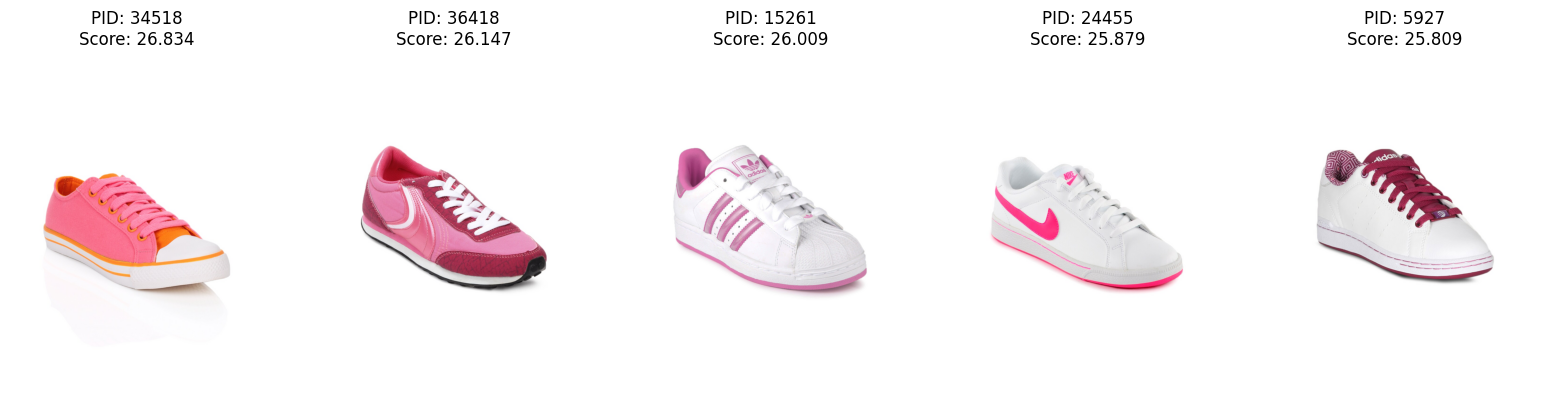

In [37]:
# 2) Display the retrieved images in a single row of subplots
plt.figure(figsize=(16, 4))
for i, (pid, score) in enumerate(zip(product_ids, sim_scores)):
    # Look up the row in df_valid to find the image path
    row = df.loc[df["ProductId"] == pid].iloc[0]
    img_path = row["full_path"]  # e.g., "D:/Anand/Jsearch_ai/..."
    
    # Open the image
    pil_img = Image.open(img_path).convert("RGB")
    
    # Create a subplot for each retrieved image
    plt.subplot(1, len(product_ids), i+1)
    plt.imshow(pil_img)
    plt.title(f"PID: {pid}\nScore: {score:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()